In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# For handling imbalanced data
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print("Ready to detect credit card fraud!")

✅ All libraries imported successfully!
Ready to detect credit card fraud!


In [6]:
# Loading the credit card fraud detection dataset
# Dataset contains transaction details including fraudulent and legitimate transactions

print("="*70)
print("LOADING CREDIT CARD FRAUD DATASET")
print("="*70)

# Reading the CSV file
df = pd.read_csv('fraudTrain.csv')

print("\n✅ Dataset loaded successfully!")
print(f"\nDataset Shape: {df.shape}")
print(f"Total Transactions: {len(df):,}")
print(f"Total Features: {df.shape[1]}")

print("\n" + "="*70)
print("FIRST 10 TRANSACTIONS")
print("="*70)
print(df.head(10))

print("\n" + "="*70)
print("DATASET INFORMATION")
print("="*70)
print(df.info())

LOADING CREDIT CARD FRAUD DATASET

✅ Dataset loaded successfully!

Dataset Shape: (1296675, 23)
Total Transactions: 1,296,675
Total Features: 23

FIRST 10 TRANSACTIONS
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   
5           5   2019-01-01 00:04:08  4767265376804500   
6           6   2019-01-01 00:04:42    30074693890476   
7           7   2019-01-01 00:05:08  6011360759745864   
8           8   2019-01-01 00:05:18  4922710831011201   
9           9   2019-01-01 00:06:01  2720830304681674   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  

In [7]:
# Understanding the dataset structure and fraud distribution

print("="*70)
print("EXPLORATORY DATA ANALYSIS")
print("="*70)

# Check for missing values
print("\n📋 Missing Values:")
print(df.isnull().sum())

# Display column names
print("\n📊 Column Names:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")

# Basic statistics
print("\n📈 Dataset Statistics:")
print(df.describe())

# Check data types
print("\n🔤 Data Types:")
print(df.dtypes)

EXPLORATORY DATA ANALYSIS

📋 Missing Values:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

📊 Column Names:
1. Unnamed: 0
2. trans_date_trans_time
3. cc_num
4. merchant
5. category
6. amt
7. first
8. last
9. gender
10. street
11. city
12. state
13. zip
14. lat
15. long
16. city_pop
17. job
18. dob
19. trans_num
20. unix_time
21. merch_lat
22. merch_long
23. is_fraud

📈 Dataset Statistics:
         Unnamed: 0 

FRAUD vs LEGITIMATE TRANSACTION ANALYSIS

Transaction Distribution:
Legitimate Transactions (0): 1,289,169
Fraudulent Transactions (1): 7,506

Percentage Distribution:
Legitimate: 99.42%
Fraudulent: 0.58%


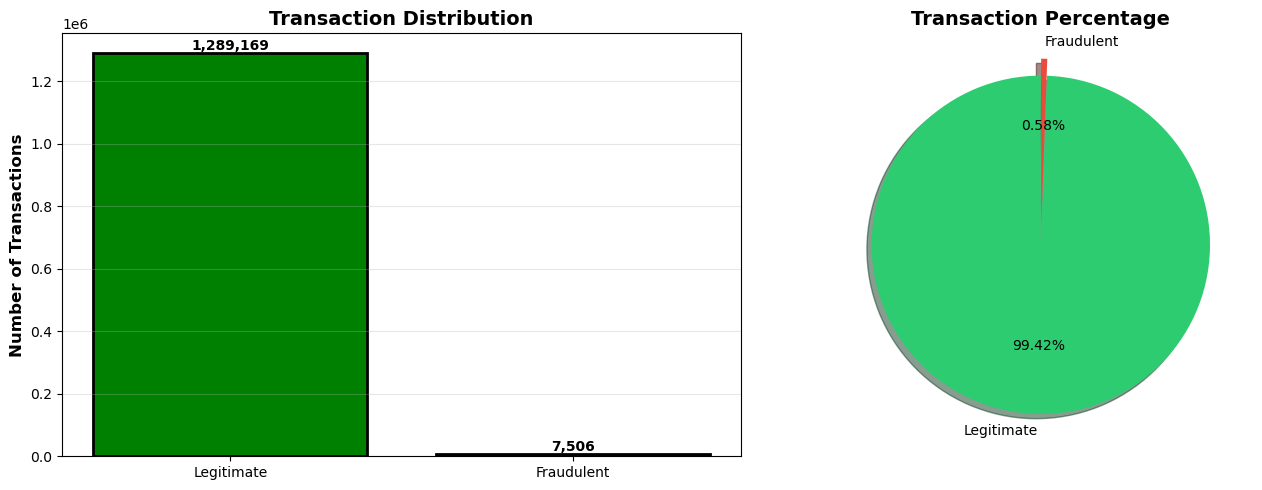


⚠️ Dataset is highly imbalanced!
We will handle this using SMOTE (Synthetic Minority Over-sampling Technique)


In [8]:
# Analyzing the distribution of fraudulent vs legitimate transactions
# This is crucial as fraud detection is typically an imbalanced classification problem

print("="*70)
print("FRAUD vs LEGITIMATE TRANSACTION ANALYSIS")
print("="*70)

# Count of fraud cases
fraud_counts = df['is_fraud'].value_counts()
print("\nTransaction Distribution:")
print(f"Legitimate Transactions (0): {fraud_counts[0]:,}")
print(f"Fraudulent Transactions (1): {fraud_counts[1]:,}")

# Calculate percentages
total = len(df)
fraud_percentage = (fraud_counts[1] / total) * 100
legitimate_percentage = (fraud_counts[0] / total) * 100

print(f"\nPercentage Distribution:")
print(f"Legitimate: {legitimate_percentage:.2f}%")
print(f"Fraudulent: {fraud_percentage:.2f}%")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(['Legitimate', 'Fraudulent'], fraud_counts.values, 
            color=['green', 'red'], edgecolor='black', linewidth=2)
axes[0].set_ylabel('Number of Transactions', fontsize=12, fontweight='bold')
axes[0].set_title('Transaction Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(fraud_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(fraud_counts.values, labels=['Legitimate', 'Fraudulent'], 
           autopct='%1.2f%%', colors=colors, startangle=90,
           explode=(0, 0.1), shadow=True)
axes[1].set_title('Transaction Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ Dataset is highly imbalanced!")
print("We will handle this using SMOTE (Synthetic Minority Over-sampling Technique)")

In [9]:
# Selecting relevant features for fraud detection
# I'm choosing numerical and important categorical features

print("="*70)
print("FEATURE SELECTION AND DATA PREPARATION")
print("="*70)

# Display all columns to understand what we have
print("\nAvailable columns:")
print(df.columns.tolist())

# Selecting important features for fraud detection
# I'm focusing on transaction amount, merchant details, and customer info
selected_features = [
    'amt',  # Transaction amount
    'lat',  # Latitude
    'long',  # Longitude
    'city_pop',  # City population
    'merch_lat',  # Merchant latitude
    'merch_long',  # Merchant longitude
]

# Adding categorical features that need encoding
categorical_features = [
    'merchant',
    'category',
    'gender',
    'state',
    'job'
]

print(f"\n📊 Selected Numerical Features: {len(selected_features)}")
for feat in selected_features:
    print(f"  - {feat}")

print(f"\n📋 Selected Categorical Features: {len(categorical_features)}")
for feat in categorical_features:
    print(f"  - {feat}")

# Target variable
target = 'is_fraud'

FEATURE SELECTION AND DATA PREPARATION

Available columns:
['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']

📊 Selected Numerical Features: 6
  - amt
  - lat
  - long
  - city_pop
  - merch_lat
  - merch_long

📋 Selected Categorical Features: 5
  - merchant
  - category
  - gender
  - state
  - job


In [10]:
# Encoding categorical variables to numerical format
# Machine learning models require numerical inputs

print("="*70)
print("ENCODING CATEGORICAL FEATURES")
print("="*70)

# Creating a copy of dataframe for processing
df_processed = df.copy()

# Label encoding for categorical features
label_encoders = {}

for feature in categorical_features:
    print(f"\nEncoding: {feature}")
    print(f"  Unique values before encoding: {df_processed[feature].nunique()}")
    
    le = LabelEncoder()
    df_processed[feature + '_encoded'] = le.fit_transform(df_processed[feature].astype(str))
    label_encoders[feature] = le
    
    print(f"  Unique values after encoding: {df_processed[feature + '_encoded'].nunique()}")

# Update feature list with encoded columns
encoded_features = [feat + '_encoded' for feat in categorical_features]
all_features = selected_features + encoded_features

print(f"\n✅ Total features for modeling: {len(all_features)}")
print("\nFinal feature list:")
for i, feat in enumerate(all_features, 1):
    print(f"{i}. {feat}")

ENCODING CATEGORICAL FEATURES

Encoding: merchant
  Unique values before encoding: 693
  Unique values after encoding: 693

Encoding: category
  Unique values before encoding: 14
  Unique values after encoding: 14

Encoding: gender
  Unique values before encoding: 2
  Unique values after encoding: 2

Encoding: state
  Unique values before encoding: 51
  Unique values after encoding: 51

Encoding: job
  Unique values before encoding: 494
  Unique values after encoding: 494

✅ Total features for modeling: 11

Final feature list:
1. amt
2. lat
3. long
4. city_pop
5. merch_lat
6. merch_long
7. merchant_encoded
8. category_encoded
9. gender_encoded
10. state_encoded
11. job_encoded


In [11]:
# Splitting data into features (X) and target (y)
# Then splitting into training and testing sets

print("="*70)
print("PREPARING TRAINING AND TESTING DATA")
print("="*70)

# Features and target
X = df_processed[all_features]
y = df_processed[target]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Train-test split (80% training, 20% testing)
# I'm using stratify to maintain fraud ratio in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\n📊 Training set: {X_train.shape[0]:,} transactions")
print(f"📊 Testing set: {X_test.shape[0]:,} transactions")

# Check fraud distribution in train/test
print(f"\nTraining set fraud distribution:")
print(y_train.value_counts())
print(f"\nTesting set fraud distribution:")
print(y_test.value_counts())

PREPARING TRAINING AND TESTING DATA

Feature matrix shape: (1296675, 11)
Target vector shape: (1296675,)

📊 Training set: 1,037,340 transactions
📊 Testing set: 259,335 transactions

Training set fraud distribution:
is_fraud
0    1031335
1       6005
Name: count, dtype: int64

Testing set fraud distribution:
is_fraud
0    257834
1      1501
Name: count, dtype: int64


In [12]:
# Scaling features to standardize the range
# Important for Logistic Regression and distance-based algorithms

print("="*70)
print("FEATURE SCALING")
print("="*70)

# StandardScaler: transforms features to have mean=0 and std=1
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled successfully!")
print(f"\nTraining data shape after scaling: {X_train_scaled.shape}")
print(f"Testing data shape after scaling: {X_test_scaled.shape}")

# Show scaling effect on first feature
print(f"\nScaling example (feature 'amt'):")
print(f"  Before scaling - Mean: {X_train['amt'].mean():.2f}, Std: {X_train['amt'].std():.2f}")
print(f"  After scaling - Mean: {X_train_scaled[:, 0].mean():.2f}, Std: {X_train_scaled[:, 0].std():.2f}")

FEATURE SCALING
✅ Features scaled successfully!

Training data shape after scaling: (1037340, 11)
Testing data shape after scaling: (259335, 11)

Scaling example (feature 'amt'):
  Before scaling - Mean: 70.34, Std: 157.06
  After scaling - Mean: -0.00, Std: 1.00


HANDLING CLASS IMBALANCE WITH SMOTE
Before SMOTE:
Training samples: 1,037,340
Fraud distribution:
is_fraud
0    1031335
1       6005
Name: count, dtype: int64

After SMOTE:
Training samples: 2,062,670
Fraud distribution:
is_fraud
0    1031335
1    1031335
Name: count, dtype: int64


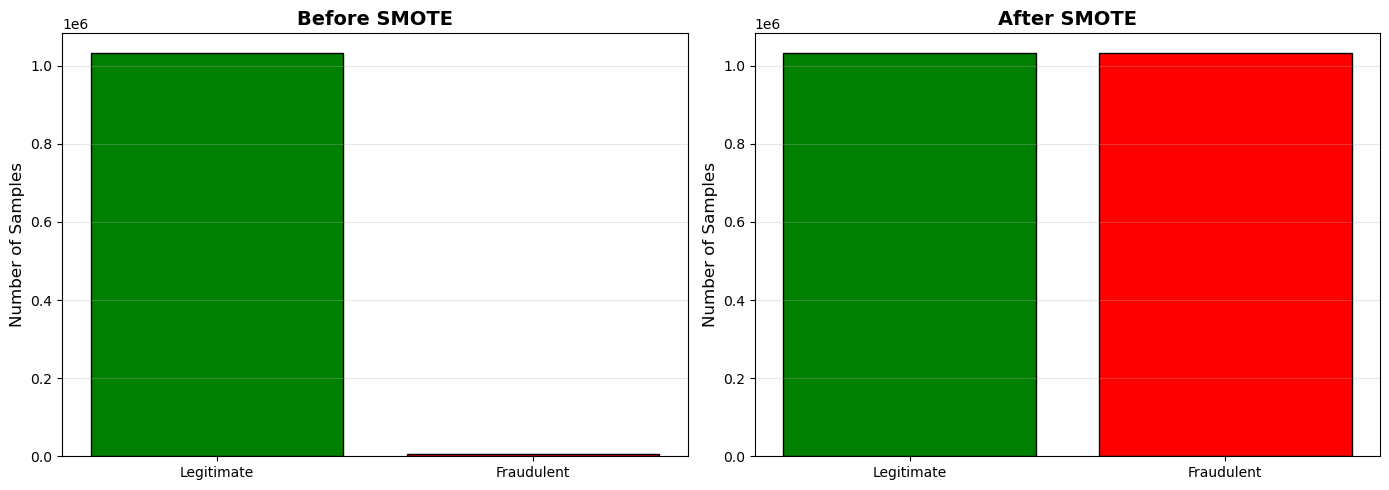


✅ Class imbalance handled successfully!


In [13]:
# Using SMOTE to balance the dataset
# SMOTE creates synthetic samples of the minority class (fraud)

print("="*70)
print("HANDLING CLASS IMBALANCE WITH SMOTE")
print("="*70)

print("Before SMOTE:")
print(f"Training samples: {len(X_train_scaled):,}")
print(f"Fraud distribution:\n{pd.Series(y_train).value_counts()}")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE:")
print(f"Training samples: {len(X_train_balanced):,}")
print(f"Fraud distribution:\n{pd.Series(y_train_balanced).value_counts()}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
before_counts = pd.Series(y_train).value_counts()
axes[0].bar(['Legitimate', 'Fraudulent'], before_counts.values, 
           color=['green', 'red'], edgecolor='black')
axes[0].set_title('Before SMOTE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# After SMOTE
after_counts = pd.Series(y_train_balanced).value_counts()
axes[1].bar(['Legitimate', 'Fraudulent'], after_counts.values, 
           color=['green', 'red'], edgecolor='black')
axes[1].set_title('After SMOTE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Class imbalance handled successfully!")

In [14]:
# Training Logistic Regression classifier
# Good baseline model, fast and interpretable

print("="*70)
print("TRAINING LOGISTIC REGRESSION MODEL")
print("="*70)

# Initialize and train
lr_model = LogisticRegression(max_iter=1000, random_state=42)

print("Training Logistic Regression...")
lr_model.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_roc_auc = roc_auc_score(y_test, y_pred_proba_lr)

print("\n✅ Logistic Regression Training Complete!")
print(f"\n📊 RESULTS:")
print(f"Accuracy:  {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"Precision: {lr_precision:.4f} ({lr_precision*100:.2f}%)")
print(f"Recall:    {lr_recall:.4f} ({lr_recall*100:.2f}%)")
print(f"F1-Score:  {lr_f1:.4f} ({lr_f1*100:.2f}%)")
print(f"ROC-AUC:   {lr_roc_auc:.4f} ({lr_roc_auc*100:.2f}%)")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_lr, 
                           target_names=['Legitimate', 'Fraudulent']))

TRAINING LOGISTIC REGRESSION MODEL
Training Logistic Regression...

✅ Logistic Regression Training Complete!

📊 RESULTS:
Accuracy:  0.9477 (94.77%)
Precision: 0.0798 (7.98%)
Recall:    0.7628 (76.28%)
F1-Score:  0.1444 (14.44%)
ROC-AUC:   0.8548 (85.48%)

📋 Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      0.95      0.97    257834
  Fraudulent       0.08      0.76      0.14      1501

    accuracy                           0.95    259335
   macro avg       0.54      0.86      0.56    259335
weighted avg       0.99      0.95      0.97    259335



In [15]:
# Training Decision Tree classifier
# Can capture non-linear patterns in data

print("="*70)
print("TRAINING DECISION TREE MODEL")
print("="*70)

# Initialize and train
# I'm limiting max_depth to prevent overfitting
dt_model = DecisionTreeClassifier(
    max_depth=10, 
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

print("Training Decision Tree...")
dt_model.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred_dt = dt_model.predict(X_test_scaled)
y_pred_proba_dt = dt_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_roc_auc = roc_auc_score(y_test, y_pred_proba_dt)

print("\n✅ Decision Tree Training Complete!")
print(f"\n📊 RESULTS:")
print(f"Accuracy:  {dt_accuracy:.4f} ({dt_accuracy*100:.2f}%)")
print(f"Precision: {dt_precision:.4f} ({dt_precision*100:.2f}%)")
print(f"Recall:    {dt_recall:.4f} ({dt_recall*100:.2f}%)")
print(f"F1-Score:  {dt_f1:.4f} ({dt_f1*100:.2f}%)")
print(f"ROC-AUC:   {dt_roc_auc:.4f} ({dt_roc_auc*100:.2f}%)")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_dt, 
                           target_names=['Legitimate', 'Fraudulent']))

TRAINING DECISION TREE MODEL
Training Decision Tree...

✅ Decision Tree Training Complete!

📊 RESULTS:
Accuracy:  0.9740 (97.40%)
Precision: 0.1714 (17.14%)
Recall:    0.9121 (91.21%)
F1-Score:  0.2886 (28.86%)
ROC-AUC:   0.9789 (97.89%)

📋 Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      0.97      0.99    257834
  Fraudulent       0.17      0.91      0.29      1501

    accuracy                           0.97    259335
   macro avg       0.59      0.94      0.64    259335
weighted avg       0.99      0.97      0.98    259335



In [16]:
# Training Random Forest classifier
# Ensemble method that combines multiple decision trees
# Usually gives best performance for fraud detection

print("="*70)
print("TRAINING RANDOM FOREST MODEL")
print("="*70)

# Initialize and train
# Using 100 trees in the forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

print("Training Random Forest (this may take a few minutes)...")
rf_model.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

print("\n✅ Random Forest Training Complete!")
print(f"\n📊 RESULTS:")
print(f"Accuracy:  {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"Precision: {rf_precision:.4f} ({rf_precision*100:.2f}%)")
print(f"Recall:    {rf_recall:.4f} ({rf_recall*100:.2f}%)")
print(f"F1-Score:  {rf_f1:.4f} ({rf_f1*100:.2f}%)")
print(f"ROC-AUC:   {rf_roc_auc:.4f} ({rf_roc_auc*100:.2f}%)")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_rf, 
                           target_names=['Legitimate', 'Fraudulent']))

TRAINING RANDOM FOREST MODEL
Training Random Forest (this may take a few minutes)...

✅ Random Forest Training Complete!

📊 RESULTS:
Accuracy:  0.9783 (97.83%)
Precision: 0.1927 (19.27%)
Recall:    0.8641 (86.41%)
F1-Score:  0.3151 (31.51%)
ROC-AUC:   0.9790 (97.90%)

📋 Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      0.98      0.99    257834
  Fraudulent       0.19      0.86      0.32      1501

    accuracy                           0.98    259335
   macro avg       0.60      0.92      0.65    259335
weighted avg       0.99      0.98      0.99    259335



In [20]:
# Comparing all three models to find the best performer
# I'm comparing multiple metrics to get complete picture

print("="*70)
print("MODEL COMPARISON")
print("="*70)

# Create comparison dataframe
comparison_data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [lr_accuracy, dt_accuracy, rf_accuracy],
    'Precision': [lr_precision, dt_precision, rf_precision],
    'Recall': [lr_recall, dt_recall, rf_recall],
    'F1-Score': [lr_f1, dt_f1, rf_f1],
    'ROC-AUC': [lr_roc_auc, dt_roc_auc, rf_roc_auc]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Performance Comparison:")
print(comparison_df.to_string(index=False))

# Find best model based on F1-Score (best metric for imbalanced data)
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_f1_score = comparison_df.loc[best_model_idx, 'F1-Score']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"🎯 F1-Score: {best_f1_score:.4f} ({best_f1_score*100:.2f}%)")

# Select best model
if best_model_name == 'Logistic Regression':
    best_model = lr_model
    y_pred_best = y_pred_lr
    y_pred_proba_best = y_pred_proba_lr
elif best_model_name == 'Decision Tree':
    best_model = dt_model
    y_pred_best = y_pred_dt
    y_pred_proba_best = y_pred_proba_dt
else:
    best_model = rf_model
    y_pred_best = y_pred_rf
    y_pred_proba_best = y_pred_proba_rf

MODEL COMPARISON

📊 Performance Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.947685   0.079758 0.762825  0.144416 0.854838
      Decision Tree  0.973976   0.171425 0.912059  0.288605 0.978947
      Random Forest  0.975179   0.165311 0.812125  0.274704 0.900880

🏆 BEST MODEL: Decision Tree
🎯 F1-Score: 0.2886 (28.86%)


VISUALIZING MODEL PERFORMANCE


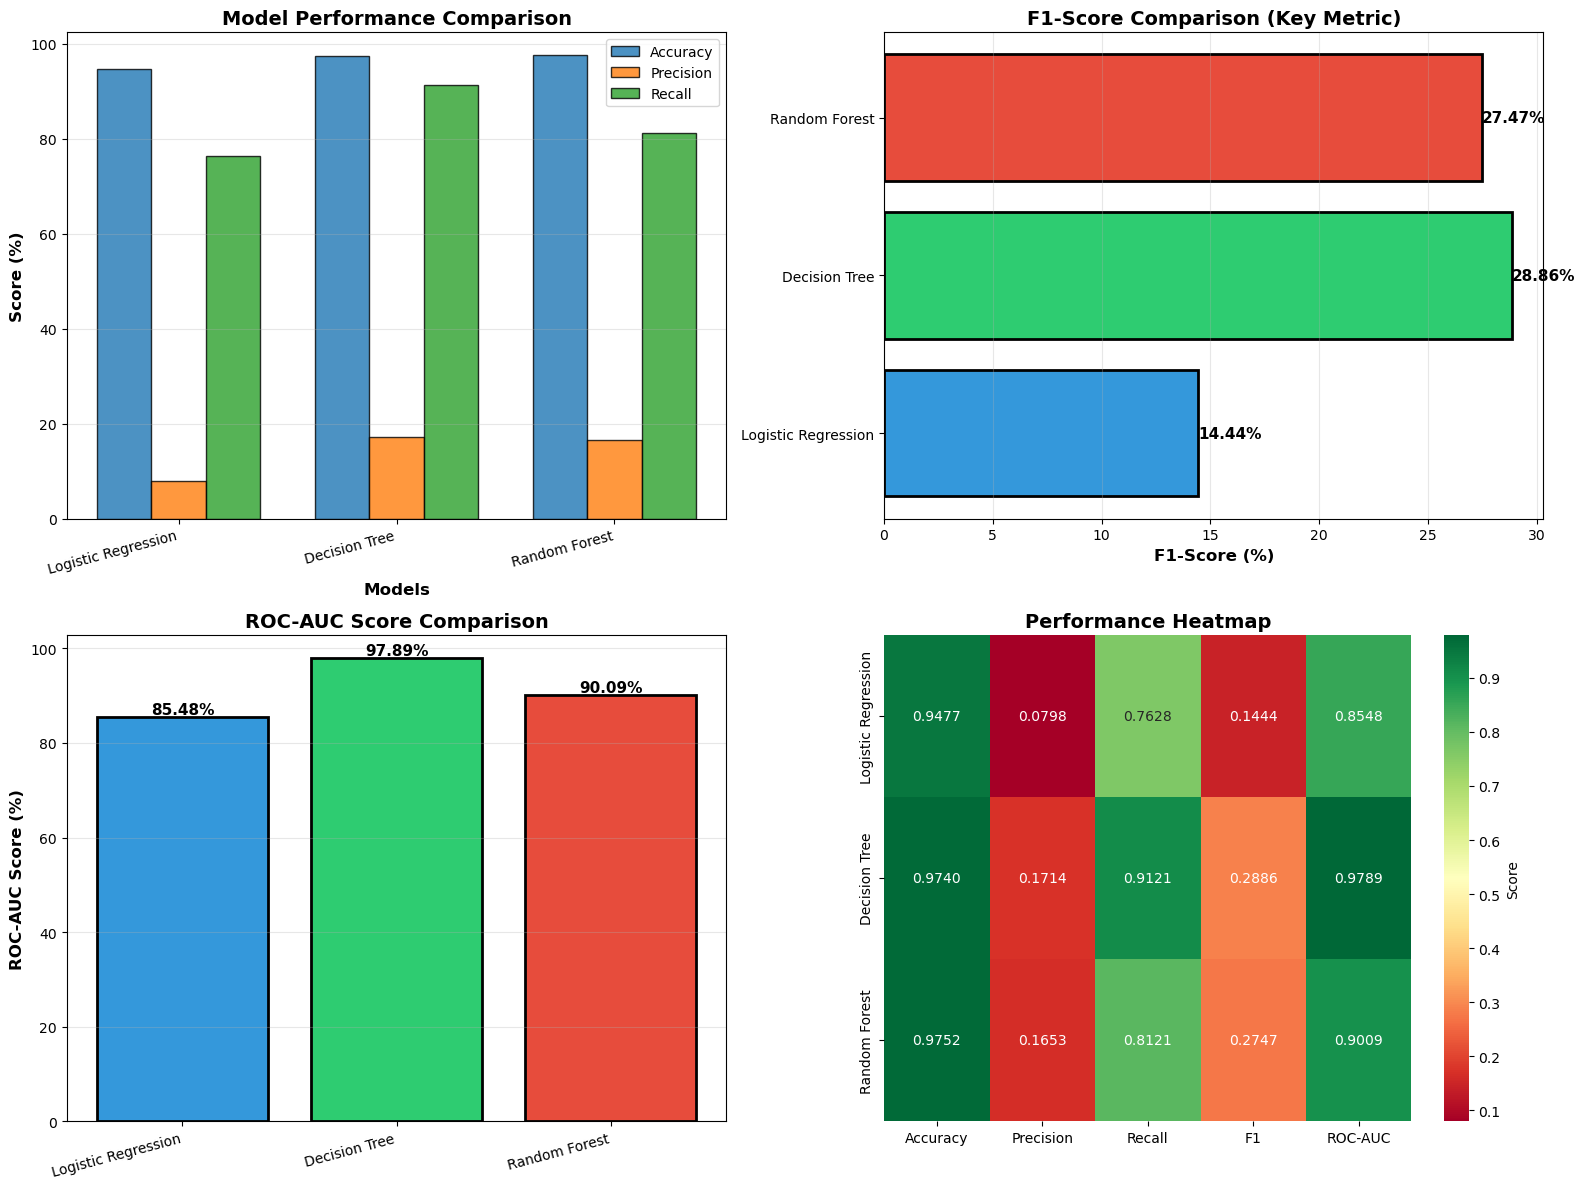


✅ Visualizations created successfully!


In [21]:
# Visualizing model performance across different metrics

print("="*70)
print("VISUALIZING MODEL PERFORMANCE")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c']

ax = axes[0, 0]
x = np.arange(len(comparison_df))
width = 0.25

for i, metric in enumerate(metrics[:3]):
    ax.bar(x + i*width, comparison_df[metric]*100, width, 
           label=metric, alpha=0.8, edgecolor='black')

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 2. F1-Score Comparison (Most Important for Fraud Detection)
ax = axes[0, 1]
bars = ax.barh(comparison_df['Model'], comparison_df['F1-Score']*100, 
               color=colors, edgecolor='black', linewidth=2)
ax.set_xlabel('F1-Score (%)', fontsize=12, fontweight='bold')
ax.set_title('F1-Score Comparison (Key Metric)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2., 
           f'{width:.2f}%',
           ha='left', va='center', fontweight='bold', fontsize=11)

# 3. ROC-AUC Comparison
ax = axes[1, 0]
bars = ax.bar(comparison_df['Model'], comparison_df['ROC-AUC']*100,
              color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('ROC-AUC Score (%)', fontsize=12, fontweight='bold')
ax.set_title('ROC-AUC Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.2f}%',
           ha='center', va='bottom', fontweight='bold', fontsize=11)

# 4. All Metrics Heatmap
ax = axes[1, 1]
metrics_data = comparison_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].values
sns.heatmap(metrics_data, annot=True, fmt='.4f', cmap='RdYlGn', 
           xticklabels=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'],
           yticklabels=comparison_df['Model'], ax=ax, cbar_kws={'label': 'Score'})
ax.set_title('Performance Heatmap', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Visualizations created successfully!")

CONFUSION MATRIX ANALYSIS

Logistic Regression:
  True Negatives (Correctly identified legitimate): 244,623
  True Positives (Correctly identified fraud): 1,145
  False Positives (Legitimate marked as fraud): 13,211
  False Negatives (Fraud marked as legitimate): 356

Decision Tree:
  True Negatives (Correctly identified legitimate): 251,217
  True Positives (Correctly identified fraud): 1,369
  False Positives (Legitimate marked as fraud): 6,617
  False Negatives (Fraud marked as legitimate): 132

Random Forest:
  True Negatives (Correctly identified legitimate): 251,679
  True Positives (Correctly identified fraud): 1,219
  False Positives (Legitimate marked as fraud): 6,155
  False Negatives (Fraud marked as legitimate): 282


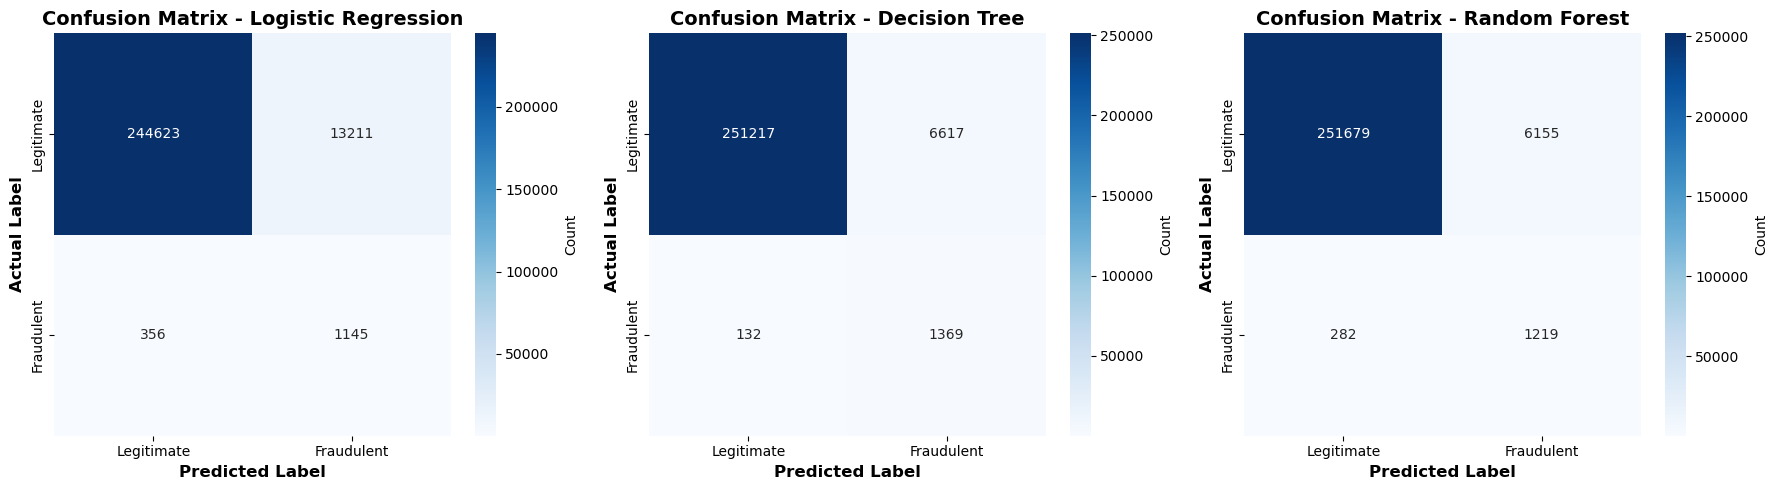

In [22]:
# Visualizing confusion matrices for all three models
# Shows True Positives, True Negatives, False Positives, False Negatives

print("="*70)
print("CONFUSION MATRIX ANALYSIS")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_data = [
    ('Logistic Regression', y_pred_lr),
    ('Decision Tree', y_pred_dt),
    ('Random Forest', y_pred_rf)
]

for idx, (model_name, y_pred) in enumerate(models_data):
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
               xticklabels=['Legitimate', 'Fraudulent'],
               yticklabels=['Legitimate', 'Fraudulent'],
               cbar_kws={'label': 'Count'})
    
    axes[idx].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual Label', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'Confusion Matrix - {model_name}', 
                       fontsize=14, fontweight='bold')
    
    # Calculate metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{model_name}:")
    print(f"  True Negatives (Correctly identified legitimate): {tn:,}")
    print(f"  True Positives (Correctly identified fraud): {tp:,}")
    print(f"  False Positives (Legitimate marked as fraud): {fp:,}")
    print(f"  False Negatives (Fraud marked as legitimate): {fn:,}")

plt.tight_layout()
plt.show()

ROC CURVE ANALYSIS


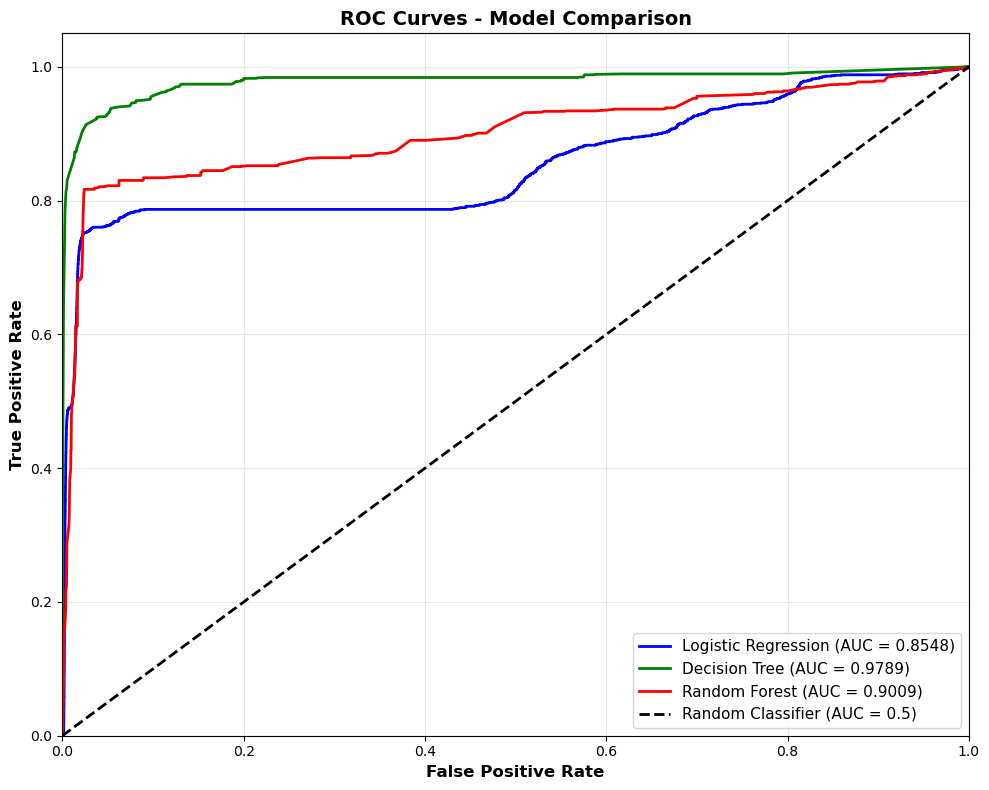


✅ ROC curves plotted!

Interpretation:
  - Closer to top-left corner = Better model
  - AUC closer to 1.0 = Better performance
  - AUC of 0.5 = Random guessing


In [23]:
# ROC Curve shows the trade-off between True Positive Rate and False Positive Rate
# Higher AUC (Area Under Curve) means better model

print("="*70)
print("ROC CURVE ANALYSIS")
print("="*70)

plt.figure(figsize=(10, 8))

# Plot ROC curves for all models
models_roc = [
    ('Logistic Regression', y_pred_proba_lr, lr_roc_auc),
    ('Decision Tree', y_pred_proba_dt, dt_roc_auc),
    ('Random Forest', y_pred_proba_rf, rf_roc_auc)
]

colors = ['blue', 'green', 'red']

for idx, (model_name, y_proba, auc_score) in enumerate(models_roc):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, color=colors[idx], linewidth=2,
            label=f'{model_name} (AUC = {auc_score:.4f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ ROC curves plotted!")
print("\nInterpretation:")
print("  - Closer to top-left corner = Better model")
print("  - AUC closer to 1.0 = Better performance")
print("  - AUC of 0.5 = Random guessing")

FEATURE IMPORTANCE ANALYSIS

📊 Top 11 Most Important Features:
         Feature  Importance
             amt    0.588660
category_encoded    0.238906
        city_pop    0.053220
merchant_encoded    0.043838
   state_encoded    0.036611
            long    0.014976
  gender_encoded    0.010919
     job_encoded    0.010455
      merch_long    0.001921
             lat    0.000481
       merch_lat    0.000012


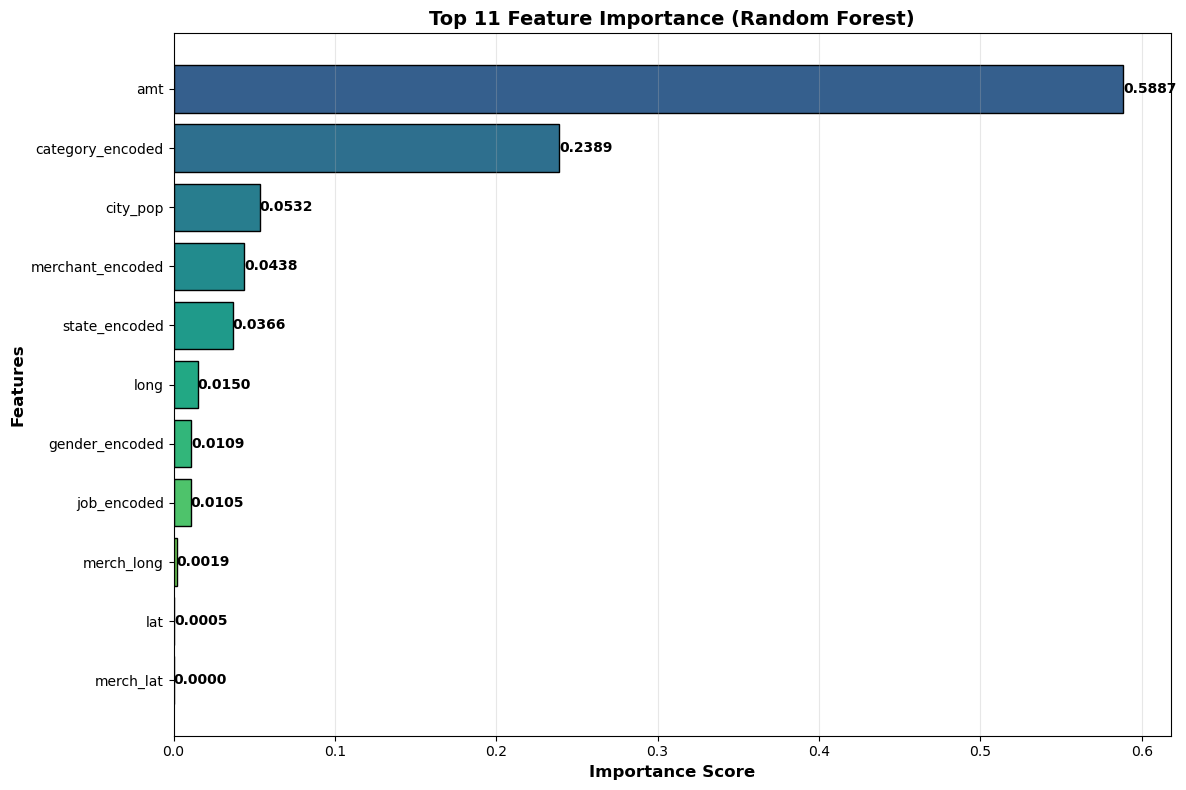


✅ Feature importance analysis complete!
Total features analyzed: 11


In [31]:

# Analyzing which features are most important for fraud detection
# Only works with tree-based models
print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature importance from Random Forest
feature_importance = rf_model.feature_importances_

# Create dataframe
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Get top features (up to 15, or however many exist)
n_features_to_show = min(15, len(importance_df))
top_features = importance_df.head(n_features_to_show)

print(f"\n📊 Top {n_features_to_show} Most Important Features:")
print(top_features.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 8))

colors_grad = plt.cm.viridis(np.linspace(0.3, 0.9, n_features_to_show))
bars = plt.barh(range(n_features_to_show), top_features['Importance'], 
                color=colors_grad, edgecolor='black')

plt.yticks(range(n_features_to_show), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title(f'Top {n_features_to_show} Feature Importance (Random Forest)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2., 
            f'{width:.4f}',
            ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Feature importance analysis complete!")
print(f"Total features analyzed: {len(importance_df)}")

In [28]:
# Save ALL test results to CSV instead of printing
print("="*70)
print("SAVING ALL TEST PREDICTIONS TO CSV")
print("="*70)

# Get test data with predictions
test_results = X_test.copy()
test_results['Actual_Fraud'] = y_test.values
test_results['Predicted_Fraud'] = y_pred_best
test_results['Fraud_Probability'] = y_pred_proba_best
test_results['Correct_Prediction'] = (test_results['Actual_Fraud'] == test_results['Predicted_Fraud'])

# Add meaningful labels
test_results['Actual_Label'] = test_results['Actual_Fraud'].map({0: 'Legitimate', 1: 'Fraud'})
test_results['Predicted_Label'] = test_results['Predicted_Fraud'].map({0: 'Legitimate', 1: 'Fraud'})
test_results['Status'] = test_results['Correct_Prediction'].map({True: 'Correct', False: 'Incorrect'})

# Save to CSV
test_results.to_csv('all_test_predictions.csv', index=False)
print(f"✅ Saved ALL {len(test_results):,} test predictions to 'all_test_predictions.csv'")

# Also save only fraud cases
fraud_cases = test_results[test_results['Actual_Fraud'] == 1]
fraud_cases.to_csv('all_fraud_cases.csv', index=False)
print(f"✅ Saved ALL {len(fraud_cases):,} fraud cases to 'all_fraud_cases.csv'")

# Display summary
print(f"\n📊 SUMMARY:")
print(f"Total Test Transactions: {len(test_results):,}")
print(f"Total Fraud Cases: {len(fraud_cases):,}")
print(f"Frauds Detected: {fraud_cases['Correct_Prediction'].sum():,}")
print(f"Frauds Missed: {(~fraud_cases['Correct_Prediction']).sum():,}")

# Show first 20 as preview
print("\n" + "="*70)
print("PREVIEW - FIRST 20 TRANSACTIONS")
print("="*70)
print(test_results[['amt', 'Actual_Label', 'Predicted_Label', 'Fraud_Probability', 'Status']].head(20))

print("\n📁 Files created:")
print("  - all_test_predictions.csv (all predictions)")
print("  - all_fraud_cases.csv (fraud cases only)")

SAVING ALL TEST PREDICTIONS TO CSV
✅ Saved ALL 259,335 test predictions to 'all_test_predictions.csv'
✅ Saved ALL 1,501 fraud cases to 'all_fraud_cases.csv'

📊 SUMMARY:
Total Test Transactions: 259,335
Total Fraud Cases: 1,501
Frauds Detected: 1,369
Frauds Missed: 132

PREVIEW - FIRST 20 TRANSACTIONS
            amt Actual_Label Predicted_Label  Fraud_Probability   Status
1161537    6.64   Legitimate      Legitimate           0.037189  Correct
192923    68.85   Legitimate      Legitimate           0.006014  Correct
1086283  122.90   Legitimate      Legitimate           0.006014  Correct
1069482   92.78   Legitimate      Legitimate           0.006014  Correct
689806    61.51   Legitimate      Legitimate           0.006014  Correct
160555     5.64   Legitimate      Legitimate           0.001531  Correct
1276446   95.53   Legitimate      Legitimate           0.001522  Correct
508306    18.62   Legitimate      Legitimate           0.121951  Correct
558111    59.13   Legitimate      Legitim

PREDICTION SUMMARY STATISTICS

📊 Overall Performance:
Total Test Transactions: 259,335
Correct Predictions: 252,586
Incorrect Predictions: 6,749
Accuracy: 97.40%

🚨 Fraud Detection Performance:
Total Actual Frauds: 1,501
Frauds Detected: 1,369
Frauds Missed: 132
Fraud Detection Rate: 91.21%

⚠️  False Alarms:
Legitimate transactions flagged as fraud: 6,617


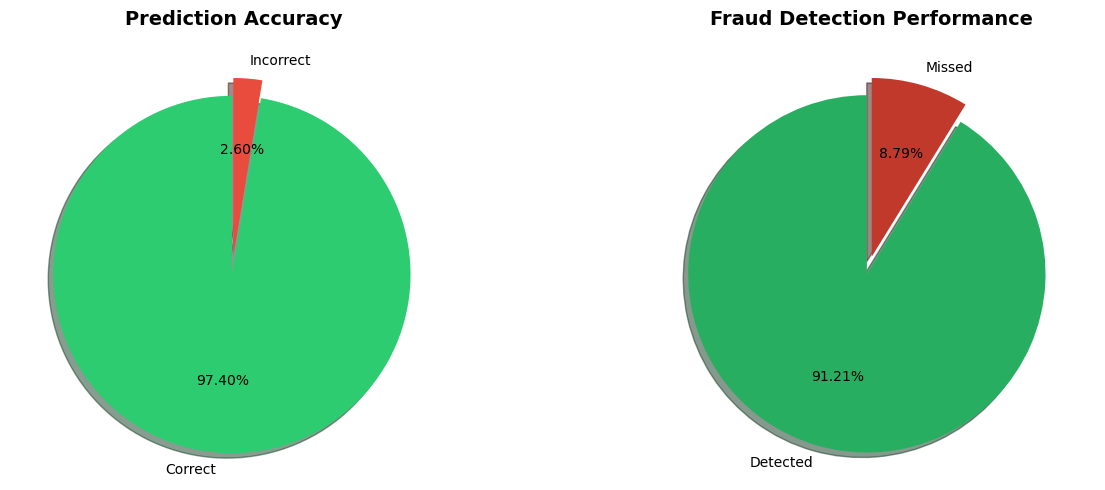

In [30]:
# Analyzing overall prediction performance on test set

print("="*70)
print("PREDICTION SUMMARY STATISTICS")
print("="*70)

# Overall statistics
total_transactions = len(test_results)
correct_predictions = test_results['Correct_Prediction'].sum()
incorrect_predictions = total_transactions - correct_predictions

accuracy_pct = (correct_predictions / total_transactions) * 100

print(f"\n📊 Overall Performance:")
print(f"Total Test Transactions: {total_transactions:,}")
print(f"Correct Predictions: {correct_predictions:,}")
print(f"Incorrect Predictions: {incorrect_predictions:,}")
print(f"Accuracy: {accuracy_pct:.2f}%")

# Fraud-specific statistics
actual_frauds = (test_results['Actual_Fraud'] == 1).sum()
detected_frauds = ((test_results['Actual_Fraud'] == 1) & 
                   (test_results['Predicted_Fraud'] == 1)).sum()
missed_frauds = actual_frauds - detected_frauds

fraud_detection_rate = (detected_frauds / actual_frauds) * 100 if actual_frauds > 0 else 0

print(f"\n🚨 Fraud Detection Performance:")
print(f"Total Actual Frauds: {actual_frauds:,}")
print(f"Frauds Detected: {detected_frauds:,}")
print(f"Frauds Missed: {missed_frauds:,}")
print(f"Fraud Detection Rate: {fraud_detection_rate:.2f}%")

# False positives (legitimate marked as fraud)
false_positives = ((test_results['Actual_Fraud'] == 0) & 
                   (test_results['Predicted_Fraud'] == 1)).sum()

print(f"\n⚠️  False Alarms:")
print(f"Legitimate transactions flagged as fraud: {false_positives:,}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prediction accuracy
ax = axes[0]
categories = ['Correct', 'Incorrect']
values = [correct_predictions, incorrect_predictions]
colors = ['#2ecc71', '#e74c3c']
ax.pie(values, labels=categories, autopct='%1.2f%%', colors=colors,
      startangle=90, explode=(0.1, 0), shadow=True)
ax.set_title('Prediction Accuracy', fontsize=14, fontweight='bold')

# Fraud detection
ax = axes[1]
categories = ['Detected', 'Missed']
values = [detected_frauds, missed_frauds]
colors = ['#27ae60', '#c0392b']
ax.pie(values, labels=categories, autopct='%1.2f%%', colors=colors,
      startangle=90, explode=(0.1, 0), shadow=True)
ax.set_title('Fraud Detection Performance', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [27]:
# Saving trained models for future use

import pickle

print("="*70)
print("SAVING TRAINED MODELS")
print("="*70)

# Save all models
models_to_save = {
    'logistic_regression_model.pkl': lr_model,
    'decision_tree_model.pkl': dt_model,
    'random_forest_model.pkl': rf_model,
    'scaler.pkl': scaler,
    'best_model.pkl': best_model
}

for filename, model in models_to_save.items():
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"✅ Saved: {filename}")

print("\n📁 Files Created:")
for filename in models_to_save.keys():
    print(f"  - {filename}")

print("\n✅ All models saved successfully!")
print("\nTo load a model later:")
print("with open('best_model.pkl', 'rb') as f:")
print("    loaded_model = pickle.load(f)")

SAVING TRAINED MODELS
✅ Saved: logistic_regression_model.pkl
✅ Saved: decision_tree_model.pkl
✅ Saved: random_forest_model.pkl
✅ Saved: scaler.pkl
✅ Saved: best_model.pkl

📁 Files Created:
  - logistic_regression_model.pkl
  - decision_tree_model.pkl
  - random_forest_model.pkl
  - scaler.pkl
  - best_model.pkl

✅ All models saved successfully!

To load a model later:
with open('best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
